<a href="https://colab.research.google.com/github/dataqueenpend/HandsOnML_projects/blob/main/Hands_on_ML_Classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

!Disclaimer - below code (with some modifications) is an exercise from Hand-On-ML exercises. Original you can find under this [link](https://github.com/dataqueenpend/handson-ml2/blob/master/03_classification.ipynb).

In [1]:
import sklearn
import numpy as np
import os

#For stable outputs across the notebook
np.random.seed(42)

#Pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Saving figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tigh_layout=True, fig_extension='png', resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
  print('Saving figure', fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.save_fig(path, format=fig_extension, dpi=resolution)

#MNIST

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

Dataset has 70 000 images. Each image has 784 features. 

---
Each image is 28 x 28 pixels, and each feature represents one pixel's intensity from 0 to 255. 

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

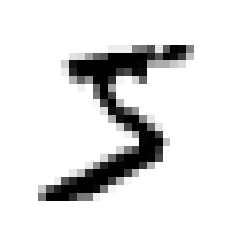

In [9]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [10]:
y[0]

'5'

Picture looks like 5. And label show it is 5. 

---

y is a string, which will be tough for the ML to deal with. Let's imput it to the integer.

In [11]:
y = y.astype(np.uint8)

##Train, test split

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Data is already shuffled, so we don't risk that some fold will be missing some digits. 

> Some ML can perform bad, if they get many similar instances in a row. But shuffling can be not such a good idea, when we're dealing with f.e. time-series data -> stock market prices, weatcher predictions etc. 

##Training Binary Classifier

For simplification of a problem let's try to train the model for predicting either the number is 5 or not. 

In [18]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

###Stochastic Gradient Descent

+ capable of handling very large datasets efficieny
  > this is because SGD handles training instances indepedently - one at a time - which make it good for online learning as well

In [14]:
#Creating SGD object and training on the whole train set

from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(random_state=42)

In [19]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

In [22]:
#Checking cross-val-score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Classifier guessed right. 

Let's try evalute the model performance. 

##Performance Measures

**Evaluation of the Classifier is trickier than evaluating regressor.**

###Cross Validation

There is part of interesting code for cross validation from handson-ml2 

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


####Cross validation with cross_val_score sklearn

In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Taking aa look at some classifier that classifies every image as not-5

In [30]:
from sklearn.base import BaseEstimator

In [31]:
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [32]:
never_5_clf = Never5Classifier()

In [33]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This classifier gueeses 100% 5. But if only 10% of the images are not 5, than the classifier is right in the 90%. 

> That's why accuracy is not the best way to evaluate performance of the classifiers. **Especially with skewed datasets**. 

###Confusion Matrix

> Evaluation by counting the number of times instances of clas A are classified as class B

  * if we know that classifier confused images of 5s with 3s, we go to the 5th row and 3rd column of the confusion matrix

